In [1]:
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import pytz

# Target Variable
## USGS Site APK 309

In [2]:
raw_well_data = '../data/raw_data/EIM-data-APK309/GroundwaterTimeSeriesResults_2023Oct19_96705.csv'


In [3]:
## Load raw data
level_data = pd.read_csv(raw_well_data,
                         low_memory=False)

In [4]:
## Restrict the data to rows where Result_Parameter_Name=='Water level in well (depth below measuring point)'
level_data = level_data.loc[level_data['Result_Parameter_Name']=='Water level in well (depth below measuring point)']
level_data = level_data.rename(columns={'Result_Value':'well_depth'})

In [5]:
## Restrict our attention to the Field_Collection_Date_Time, Result_Value, and Time_Zone columns
level_data[['Field_Collection_Date_Time','well_depth']].sort_values(by='Field_Collection_Date_Time')

,Field_Collection_Date_Time,well_depth
10,1/1/2007 10:00:00 AM,47.370
22,1/1/2007 10:00:00 PM,47.340
11,1/1/2007 11:00:00 AM,47.380
23,1/1/2007 11:00:00 PM,47.340
0,1/1/2007 12:00:00 AM,47.380
...,...,...
66425,9/9/2017 7:00:00 PM,47.985
66414,9/9/2017 8:00:00 AM,47.976
66426,9/9/2017 8:00:00 PM,47.991
66415,9/9/2017 9:00:00 AM,47.965


In [6]:
## Construct a localized timestamp for each measurment and store it in a datetime_recorded column
tz_dict = {'PDT - Pacific Daylight Time (GMT-7)':'Etc/GMT-7', 
           'PST - Pacific Standard Time (GMT-8)':'Etc/GMT-8'}

level_data['Time_Zone']=level_data['Time_Zone'].apply(lambda x: tz_dict[x])

level_data['Field_Collection_Date_Time'] = pd.to_datetime(
    level_data['Field_Collection_Date_Time'], format = '%m/%d/%Y %H:%M:%S %p', utc=False)

times = level_data.Field_Collection_Date_Time.values
zones = level_data.Time_Zone.values
localized_times = []
for time, zone in zip(times, zones):
    localized_times.append(pd.Timestamp(time).tz_localize(zone))

level_data['datetime_recorded'] = localized_times

## Sort by the timestamps
level_data = level_data.sort_values('datetime_recorded')
level_data = level_data.reset_index(drop=True)

In [7]:
## Extract the date to a column
level_data['date'] = level_data['datetime_recorded'].dt.date

In [8]:
## Group measurments recorded on the same date, and compute their average as the daily avg_well_depth
level_data['avg_well_depth'] = level_data.groupby('date')['well_depth'].transform('mean')

In [9]:
## Gather the columns we want, in the order we want
level_data = level_data.drop_duplicates('date')[['date','avg_well_depth']]

# Feature Variables

## Surface Water Data from the USGS

USGS Site No: 12422500 [link](https://waterdata.usgs.gov/nwis/inventory?site_no=12422500)

This site is reports the following data for the Spokane River in Spokane, WA:
- Discharge, cubic feet per second (Mean)
- Gage height, feet (Mean)

### Importing and prepping
- Load the raw data
- Get the columns we want: `datetime_recorded`, `discharge_cfs`, and `gage_ht`)
- Make the datatypes make sense
- Extract the `year`, `month`, and `day` as columns from the timestamp
- Break the data into two sets:
    - Gage height:
        - Restrict to 2005 and beyond
        - Fill in missing values with the last non-missing value before the gap
    - Discharge rate:
        - Keep all the data
     
The result is two dataframes:
- `sw_data_gage_ht` with the following columns:
    - `date`
    - `gage_ht`
- `sw_data_discharge_cfs` with the following columns:
    - `date`
    - `discharge_cfs` 

In [10]:
## Load the raw data
sw_data = pd.read_csv('../data/raw_data/USGS-Surface-Water-Site-12422500.tsv',
                      low_memory=False,
                      delimiter='\t',
                      comment='#')

## Drop meaningless top row
sw_data = sw_data.drop(0, axis=0)

In [11]:
## Grab the columns we want
sw_data = sw_data[['datetime','149640_00060_00003','149641_00065_00003']]

## Rename the columns to something more meaningful
headers = {'datetime':'datetime_recorded', '149640_00060_00003':'discharge_cfs', '149641_00065_00003':'gage_ht'}
sw_data = sw_data.rename(columns=headers)

## Make the column datatypes useful
sw_data['datetime_recorded'] = pd.to_datetime(sw_data['datetime_recorded'])
sw_data['discharge_cfs'] = sw_data['discharge_cfs'].astype(float)
sw_data['gage_ht'] = sw_data['gage_ht'].astype(float)

## Sort the data by the timestamp
sw_data = sw_data.sort_values('datetime_recorded')
sw_data = sw_data.reset_index(drop=True)

In [12]:
## Extract the date as columns from the timestamp
sw_data['date']=sw_data.datetime_recorded.dt.date

In [13]:
## Restrict our attention to 2005 and beyond for the gage_ht
#sw_data_gage_ht = sw_data.loc[sw_data.datetime_recorded>=datetime(2005,1,1)][['date','gage_ht']].copy()
sw_data_gage_ht = sw_data.loc[sw_data.datetime_recorded>=datetime(1900,10,21)][['date','gage_ht']].copy()
## Fill missing gage_ht values with the last value before the gap
#sw_data_gage_ht = sw_data_gage_ht.fillna(method='ffill')

## Keep all of the discharge data
sw_data_discharge_cfs = sw_data[['date','discharge_cfs']].copy()

## Precipitation Data from NOAA

Using data from the National Oceianic and Atmospheric Administration's (NOAA) National Centers for Environmental Information (NCEI) database, we ordered the following data from Spokane County, WA (FIPS:53063), for the dates 2005-01-01 through 2019-12-31.

- EVAP - Evaporation of water from evaporation pan
- DAPR - Number of days included in the multiday precipitation total (MDPR)
- SX52 - Maximum soil temperature with sod cover at 10 cm depth
- SNOW - Snowfall
- WESF - Water equivalent of snowfall
- PRCP - Precipitation
- MXPN - Daily maximum temperature of water in an evaporation pan
- SNWD - Snow depth
- WESD - Water equivalent of snow on the ground
- PSUN - Daily percent of possible sunshine for the period
- MNPN - Daily minimum temperature of water in an evaporation pan
- MDPR - Multiday precipitation total (use with DAPR and DWPR, if available)
- SN52 - Minimum soil temperature with sod cover at 10 cm depth
- TSUN - Total sunshine for the period

Data is provided for several stations. we will use `USW00024157`, which is the weather station at the Spokane airport. We only want the precipitation (`PRCP`) information from this site.

From the documentation, this data is provided as:
> Precipitation - Total Liquid Content (TLC): Water equivalent amount of precipitation for the day (in inches to hundredths). This is all types of precipitation (melted and frozen). T indicates trace amount of precipitation. If left blank, precipitation amount is unreported.

The result is a dataframe called `noaa_data` with the following columns:
- `date`
- `prcp`


In [14]:
noaa_data = pd.read_csv('../data/raw_data/noaa-data.csv', parse_dates=['DATE'], low_memory=False)
noaa_data['date']=noaa_data.DATE.dt.date
noaa_data = noaa_data.loc[noaa_data.STATION=='USW00024157'][['date','PRCP']].copy()
noaa_data = noaa_data.rename(columns={'PRCP':'prcp'})

## Weather Data from Openweather.com

Bulk weather history data is available for purchase [here](https://home.openweathermap.org/marketplace)

For Spokane, WA, the following hourly measurments (starting in 1979) are available:
- Temperature (Fahrenheit)
- Min temperature (Fahrenheit)
- Max temperature (Fahrenheit)
- Feels like (Fahrenheit)
- Pressure (hPa)
- Humidity (%)
- Clouds (%)
- Weather conditions
- Rain (mm/h)
- Snow (mm/h)
- Dew point (Fahrenheit)
- Visibility (metres)
- Wind (speed, direction, gust) (miles/hour, degrees, miles/hour)

Of theses, we will be keeping:
- Temperature (Fahrenheit)
    - As the average daily temperature `temp_avg`, max daily temperature `temp_max`, and minimum daily temperature `temp_min`
- Pressure (hPa)
    - As the average daily pressure `hPa_avg` 
- Humidity (%)
    - As the average daily `hum_avg`, max daily `hum_max`, min daily `hum_min`
- Wind Speed (avg, max, min mph) `wind_avg`, `wind_max`, `wind_min`
- Wind Gust (avg, max, min mph) `gust_avg`, `gust_max`, `gust_min`

### Importing and Prepping
- Import raw data
- Create localized timestamps
- Add a date column
- Restrict to the columns of interest
- Fill `NaN` with `0`
- Compute `temp_avg`, `temp_max`, `temp_min`, `hPa_avg`, `hum_avg`, `hum_max`, `hum_min`, `wind_avg`, `wind_max`, `wind_min`, `gust_avg`, `gust_max`, and `gust_min`

The result is a dataframed called `wx_data` with the following columns:
- `date`
- `temp_avg`
- `temp_max`
- `temp_min`
- `hPa_avg`
- `hum_avg`
- `hum_max`
- `hum_min`
- `wind_avg`
- `wind_max`
- `wind_min`
- `gust_avg`
- `gust_max`
- `gust_min`

In [15]:
## Import raw data
wx_data = pd.read_csv('../data/raw_data/open-weather-spokane.csv')

In [16]:
## Create localized timestamps
def trunc(isodt):
    return isodt[0:-10]

wx_data['dt_iso'] = wx_data['dt_iso'].apply(trunc)

wx_data['dt_iso'] = pd.to_datetime(wx_data['dt_iso'],
                                       utc=True)
wx_data['datetime_recorded'] = wx_data['dt_iso'].dt.tz_convert('US/Pacific')

wx_data = wx_data.sort_values('datetime_recorded')
wx_data = wx_data.reset_index(drop=True)

In [17]:
## Add a date column
wx_data['date'] = wx_data.datetime_recorded.dt.date

In [18]:
## Restrict to the columns of interest
wx_data = wx_data[['date',
                   'temp',
                   'pressure', 
                   'humidity', 
                   'wind_speed',
                   'wind_gust']].copy()

In [19]:
## Fill NaN values with zeros
#wx_data = wx_data.fillna(0)
## Fix outliers
wx_data.loc[287040,'temp']=10.09

In [20]:
'''
Compute the following:
`temp_avg`, `temp_max`, `temp_min`, 
`hPa_avg`, 
`hum_avg`, `hum_max`, `hum_min`, 
`wind_avg`, `wind_max`, `wind_min`, 
`gust_avg`, `gust_max`, `gust_min`
''' 
wx_data['temp_avg'] = wx_data.groupby('date')['temp'].transform('mean')
wx_data['temp_max'] = wx_data.groupby('date')['temp'].transform('max')
wx_data['temp_min'] = wx_data.groupby('date')['temp'].transform('min')
wx_data['hPa_avg'] = wx_data.groupby('date')['pressure'].transform('mean')
wx_data['hum_avg'] = wx_data.groupby('date')['humidity'].transform('mean')
wx_data['hum_max'] = wx_data.groupby('date')['humidity'].transform('max')
wx_data['hum_min'] = wx_data.groupby('date')['humidity'].transform('min')
wx_data['wind_avg'] = wx_data.groupby('date')['wind_speed'].transform('mean')
wx_data['wind_max'] = wx_data.groupby('date')['wind_speed'].transform('max')
wx_data['wind_min'] = wx_data.groupby('date')['wind_speed'].transform('min')
wx_data['gust_avg'] = wx_data.groupby('date')['wind_gust'].transform('mean')
wx_data['gust_max'] = wx_data.groupby('date')['wind_gust'].transform('max')
wx_data['gust_min'] = wx_data.groupby('date')['wind_gust'].transform('min')

In [21]:
wx_data = wx_data.drop_duplicates('date')[['date',
                                               'temp_avg', 'temp_max', 'temp_min', 
                                               'hPa_avg',
                                               'hum_avg', 'hum_max', 'hum_min',
                                               'wind_avg', 'wind_max', 'wind_min', 
                                               'gust_avg', 'gust_max', 'gust_min']].copy()

# Merging and Pickling
After merging, the result is a dataframe called `all_data` with the following columns:
- `date` - The date the measurements were recorded
- `avg_well_depth` - The average of the daily well measurements, in feet from the surface
- `gage_ht` - The gage height of the river, in feet
- `discharge_cfs` - The discharge rate of the river in cubic feet per second
- `temp_avg` - The average daily temperature in Fahrenheit
- `temp_max` - The daily maximum temperature in Fahrenheit
- `temp_min` - The daily minimum temperature in Fahrenheit
- `hPa_avg` - The daily average pressure in hectopascals
- `hum_avg` - The average daily humidity in percent
- `hum_max` - The daily maximum humidity in percent
- `hum_min` - The daily minimum humidity in percent
- `prcp` - The daily precipitation total in inches
- `wind_avg` - The average daily wind speed in miles per hour
- `wind_max` - The daily maximum (hourly) wind speed in miles per hour
- `wind_min` - The daily minimum (hourly) wind speed in miles per hour
- `gust_avg` - The average daily wind gust speed in miles per hour
- `gust_max` - The daily maximum wind gust speed in miles per hour
- `gust_min` - The daily minimum wind gust speed in miles per hour

In [22]:
all_data = level_data.merge(sw_data_gage_ht, how='outer', on='date')
all_data = all_data.merge(sw_data_discharge_cfs, how='outer', on='date')
all_data = all_data.merge(noaa_data, how='outer', on='date')
all_data = all_data.merge(wx_data, how='outer', on='date')
all_data = all_data.sort_values('date')
wx_data = wx_data.reset_index(drop=True)

In [23]:
all_data = all_data.set_index('date')
#all_data = all_data.reset_index(drop=True)
all_data

,avg_well_depth,gage_ht,discharge_cfs,prcp,temp_avg,temp_max,temp_min,hPa_avg,hum_avg,hum_max,hum_min,wind_avg,wind_max,wind_min,gust_avg,gust_max,gust_min
date,,,,,,,,,,,,,,,,,
1900-10-21,NaN,NaN,2410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-10-22,NaN,NaN,2750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-10-23,NaN,NaN,3100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-10-24,NaN,NaN,3280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-10-25,NaN,NaN,3460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17,NaN,17.94,1470.0,NaN,53.655000,61.41,43.72,1020.958333,61.208333,80.0,40.0,9.831667,18.41,0.00,NaN,NaN,NaN
2023-10-18,NaN,17.95,1480.0,NaN,55.562083,72.59,42.53,1021.166667,58.708333,83.0,28.0,5.322917,10.36,0.00,NaN,NaN,NaN
2023-10-19,NaN,17.95,1480.0,NaN,57.589167,76.69,42.44,1017.958333,62.375000,87.0,34.0,7.910417,16.11,0.00,NaN,NaN,NaN


In [24]:
"""
    visualize the percentage of missing values in each columns
"""

def get_percentage_nan_values(data, thresh=100, color='black', edgecolor='black', width=15, height=3):
   
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

def show_distribution_nan_values(df):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    sns.heatmap(df.T.isna(), cmap='Blues')
    ax.set_title('Fields with Missing Values', fontsize=16)
    #for tick in ax.xaxis.get_major_ticks():
    #    tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    return plt.show()

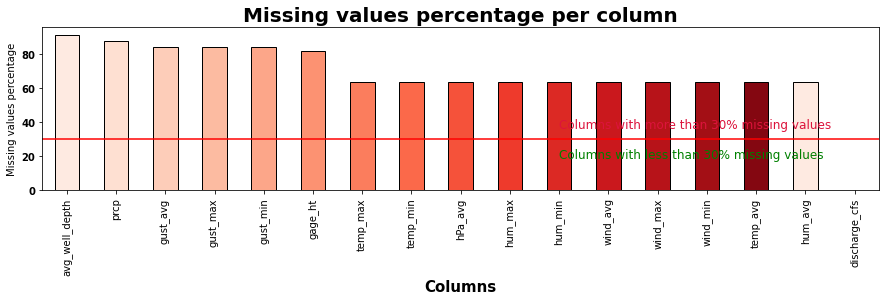

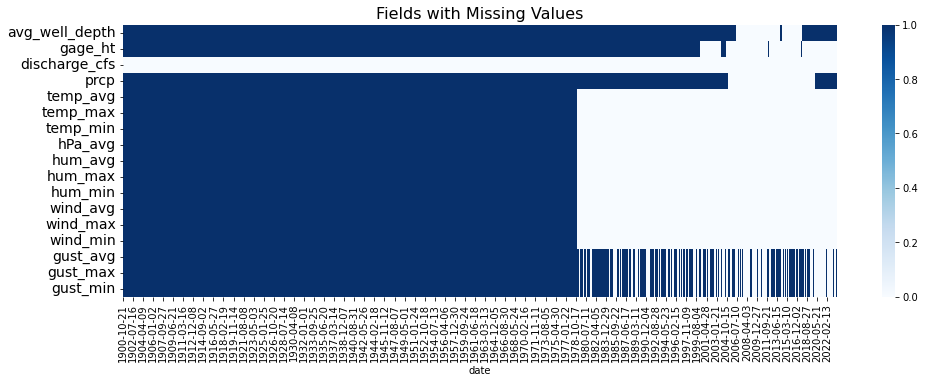

In [25]:
# show percentage and distribution missing values per columns
get_percentage_nan_values(all_data, 30, color=sns.color_palette('Reds',15))
show_distribution_nan_values(all_data)

In [26]:
# select data after 2006-01-01
all_data.index = pd.to_datetime(all_data.index)
all_data = all_data[(all_data.index >='2006-02-07') & (all_data.index <='2017-09-28')]

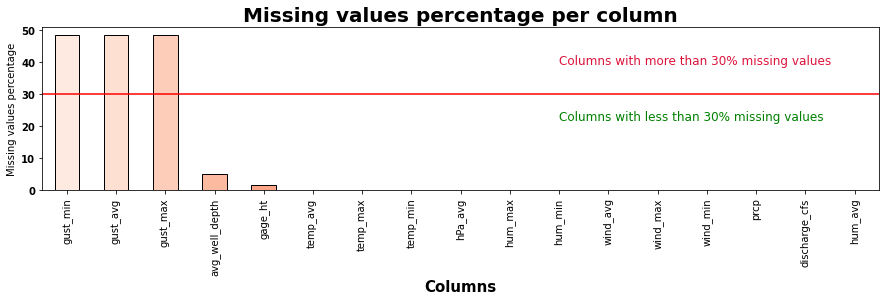

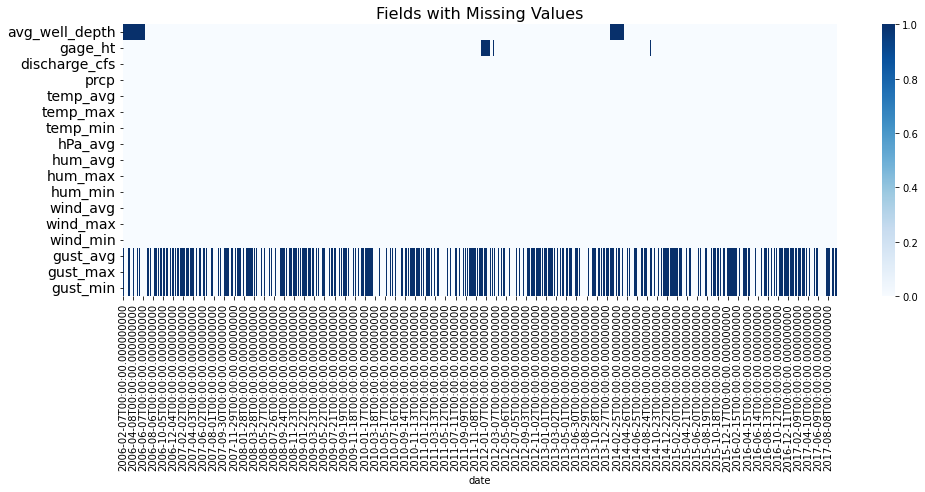

In [27]:
# show percentage and distribution missing values per columns
get_percentage_nan_values(all_data, 30, color=sns.color_palette('Reds',15))
show_distribution_nan_values(all_data)